# The final DpoDetection Tool :
***

In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase/checkpoint-198/"
DpoDetection_path = f"{path_work}/DepoDetection.S1.conv.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)

/home/concha-eloko/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /media/concha-eloko/Linux/depolymerase_building/esm2_t12_35M_UR50D-finetuned-depolymerase/checkpoint-198/ were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

In [2]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  
        self.fc1 = nn.Linear(64 * (self.max_length - (5 - 1)), 32)  
        self.classifier = nn.Linear(32, 2)

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) 
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  
        outputs = outputs.float()  
        
        out = F.relu(self.conv1(outputs))
        out = out.view(batch_size, -1)
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

In [3]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0): EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False

In [4]:
def predict_sequence(model, sequence):
    model.eval()  
    with torch.no_grad():   
        outputs, sequence_outputs = model([sequence])
        probas = torch.nn.functional.softmax(outputs, dim=-1)
        predictions = torch.argmax(probas, dim=1)  
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]  
        prob_predicted = probas[0][predictions].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list

def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        else:
            color = 'red'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

In [10]:
input_fasta = "MGLHVQKSQLSVIKLGDYGAVGDGVTDDTTSFINLEAEHKGKIINLEFKTYLVDKGFSGNFYINGSFKVGDNTFAAPYTLPYANNSNIFMGENSGVNTDKYPVYMASAGGYSNIGIGKNALKSNTEGWRNVAIGDGALVNNTLGHYNIAVGDEALRDNIGSRNGDSTDNGSRNTAVGSNTMCYNTTGYCNTAMGRNALHTNFTGYHNTAIGAAALSGNAPYVNGVVVPDDPKHGNYNTAVGSEALFRGNSDHNTAVGRSAAWNTKNGARNVAIGSEALYYNEANVTYDDKTTAGAGNTAVGTAAMKYMQDGSQATLVNNSSAIGYGARVSGDNQVQLGGSGTTTYSYGAVQSRSDQRDKTDIKDTELGLDFLLKVRPVDFRWDYRDDYQEIDEEGNLITHEKDGSRSGNRFHHGVIAQEIQEVIQKTGKDFGGLQDHKINGGTDVLSIGYEEFIAPIIKSIHELHKMVSDLSDRISELENK"

prediction , token = predict_sequence(model_classifier ,input_fasta)


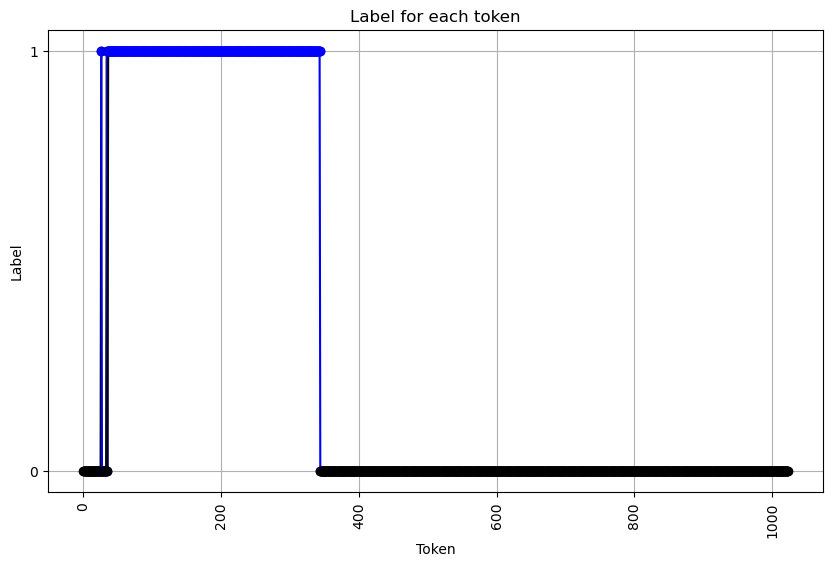

((1, 0.9974331259727478), None)

In [11]:
prediction  , plot_token(token)

In [8]:
token

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

***
# DpoDetectionTool BIG :

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
from Bio import SeqIO
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

esm2_model_path = "/home/conchae/PhageDepo_pdb/script_files/models/esm2_t30_150M_UR50D-finetuned-depolymerase/checkpoint-198"
DpoDetection_path = f"/home/conchae/PhageDepo_pdb/DepoDetection.t30_150M.conv2L.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)

In [ ]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1026
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer 1 
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer 2
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 2)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

In [ ]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


In [ ]:
def predict_sequence(model, sequence):
    model.eval()  
    with torch.no_grad():   
        outputs, sequence_outputs = model([sequence])
        probas = torch.nn.functional.softmax(outputs, dim=-1)
        predictions = torch.argmax(probas, dim=1)  
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]  
        prob_predicted = probas[0][predictions].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list

def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        else:
            color = 'red'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

In [9]:
input_fasta = "MGLHVQKSQLSVIKLGDYGAVGDGVTDDTTSFINLEAEHKGKIINLEFKTYLVDKGFSGNFYINGSFKVGDNTFAAPYTLPYANNSNIFMGENSGVNTDKYPVYMASAGGYSNIGIGKNALKSNTEGWRNVAIGDGALVNNTLGHYNIAVGDEALRDNIGSRNGDSTDNGSRNTAVGSNTMCYNTTGYCNTAMGRNALHTNFTGYHNTAIGAAALSGNAPYVNGVVVPDDPKHGNYNTAVGSEALFRGNSDHNTAVGRSAAWNTKNGARNVAIGSEALYYNEANVTYDDKTTAGAGNTAVGTAAMKYMQDGSQATLVNNSSAIGYGARVSGDNQVQLGGSGTTTYSYGAVQSRSDQRDKTDIKDTELGLDFLLKVRPVDFRWDYRDDYQEIDEEGNLITHEKDGSRSGNRFHHGVIAQEIQEVIQKTGKDFGGLQDHKINGGTDVLSIGYEEFIAPIIKSIHELHKMVSDLSDRISELENK"

prediction , token = predict_sequence(model_classifier ,input_fasta)


>Move the sequences to the server : 

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/77_strains_phage_project/DetectedDpo.77_phages.multi.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb 
    
rsync -avzhe ssh \
/media/concha-eloko/Linux/77_strains_phage_project/MissedDpos.77_phages.multi.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb 


In [ ]:
fasta_1 = "/home/conchae/PhageDepo_pdb/DetectedDpo.77_phages.multi.fasta"
fasta_2 = "/home/conchae/PhageDepo_pdb/MissedDpos.77_phages.multi.fasta"

path_fastas = [fasta_1 , fasta_2]

with open(f"/home/conchae/PhageDepo_pdb/77_Dpo_results.DepoDetection.t30_150M.conv2L.out" , "w") as outfile :
    for fasta in path_fastas :
        outfile.write(f"{fasta.split('/')[-1]}\n")
        sequences = SeqIO.parse(fasta , "fasta")
        for record in sequences : 
            prediction , token = predict_sequence(model_classifier , str(record.seq))
            outfile.write(f"{record.description}\t{prediction[0]}__{prediction[1]}\t{','.join(token)}\n")
            outfile.write(f"{record.description}\t{str(prediction)}\t{token}\n")

In [ ]:
#!/bin/bash
#BATCH --job-name=big_pred__
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=50gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=big_pred__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings


python /home/conchae/PhageDepo_pdb/script_files/prediction_big.py